In [1]:

%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [ ]:

from FRVRS import nu, fu
from pandas import DataFrame
import numpy as np
import pandas as pd
import re

In [3]:

# load data frames
data_frames_list = nu.load_data_frames(frvrs_logs_df='')

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.


In [4]:

frvrs_logs_df = data_frames_list['frvrs_logs_df']

In [5]:

# 
from tqdm import tqdm

mask_series = ~frvrs_logs_df.patient_salt.isnull()
gb = frvrs_logs_df[mask_series].sort_values(['action_tick']).groupby(fu.patient_groupby_columns)
rows_list = []
for (session_uuid, scene_id, patient_id), _ in tqdm(gb, total=gb.size().shape[0]):
    
    # Get patient's entire history
    patient_mask_series = True
    for cn in fu.patient_groupby_columns: patient_mask_series &= (frvrs_logs_df[cn] == eval(cn))
    if patient_mask_series.any():
        patient_df = frvrs_logs_df[patient_mask_series].sort_values('action_tick')
        
        patient_salt = fu.get_max_salt(patient_df)
        assert not pd.isna(patient_salt), "patient_salt is NaN"
        is_patient_severely_hemorrhaging = fu.get_is_patient_severely_hemorrhaging(patient_df)
        assert not pd.isna(patient_salt), "is_patient_severely_hemorrhaging is NaN"
        is_life_threatened = fu.get_is_life_threatened(patient_df)
        assert not pd.isna(patient_salt), "is_life_threatened is NaN"
        
        row_dict = {}
        for cn in fu.patient_groupby_columns: row_dict[cn] = eval(cn)
        row_dict['patient_salt'] = patient_salt
        row_dict['is_patient_severely_hemorrhaging'] = is_patient_severely_hemorrhaging
        row_dict['is_life_threatened'] = is_life_threatened
        rows_list.append(row_dict)
life_threatened_df = DataFrame(rows_list)
life_threatened_df.patient_salt = life_threatened_df.patient_salt.astype(fu.salt_category_order)
life_threatened_df.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5784/5784 [07:08<00:00, 13.49it/s]


(5784, 6)

In [6]:

import matplotlib.pyplot as plt

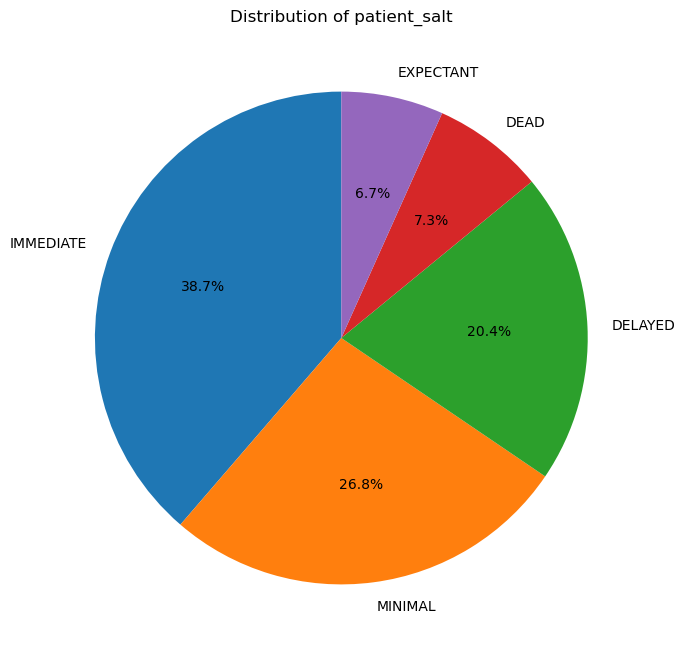

In [7]:

nu.plot_grouped_pie_chart(life_threatened_df, 'patient_salt', 'Other SALTs', slice_cutoff=None, verbose=False)

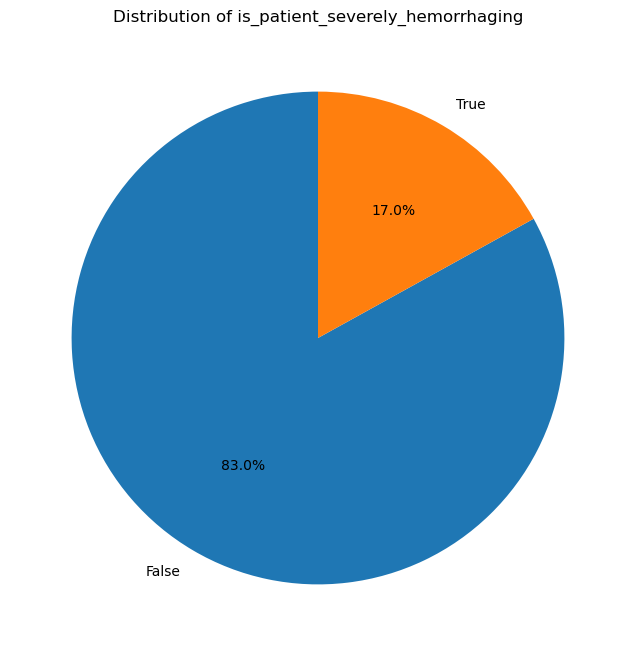

In [8]:

nu.plot_grouped_pie_chart(life_threatened_df, 'is_patient_severely_hemorrhaging', 'Other SALTs', slice_cutoff=None, verbose=False)

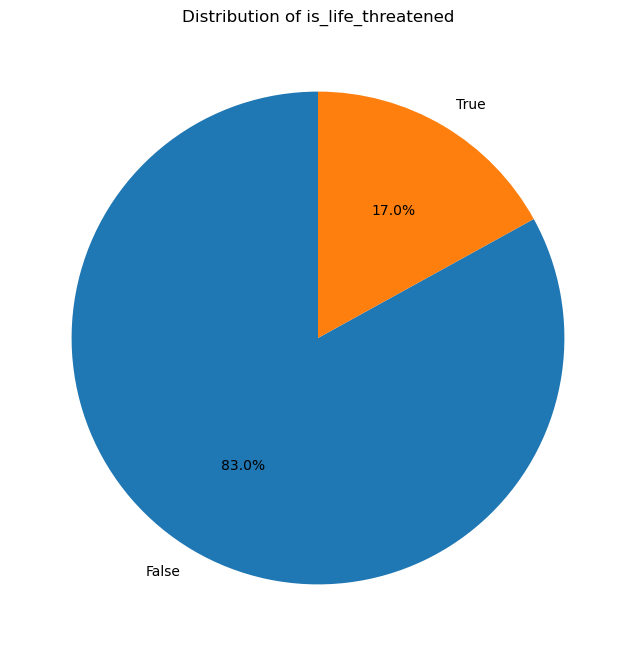

In [9]:

nu.plot_grouped_pie_chart(life_threatened_df, 'is_life_threatened', 'Other SALTs', slice_cutoff=None, verbose=False)

In [10]:

groupby_columns = ['patient_salt', 'is_patient_severely_hemorrhaging', 'is_life_threatened']
life_threatened_df[groupby_columns].drop_duplicates().sort_values(groupby_columns)

,patient_salt,is_patient_severely_hemorrhaging,is_life_threatened
639,DEAD,False,False
0,DEAD,True,True
2,EXPECTANT,False,False
4857,EXPECTANT,False,True
358,EXPECTANT,True,True
3,IMMEDIATE,False,False
7,IMMEDIATE,True,True
4,DELAYED,False,False
1,MINIMAL,False,False


In [11]:

df = life_threatened_df.groupby(groupby_columns).size().to_frame().reset_index(drop=False).rename(columns={0: 'combo_size'}).sort_values('combo_size')
mask_series = (df.combo_size == 0)
df[~mask_series]

,patient_salt,is_patient_severely_hemorrhaging,is_life_threatened,combo_size
5,EXPECTANT,False,True,1
0,DEAD,False,False,9
7,EXPECTANT,True,True,18
4,EXPECTANT,False,False,369
3,DEAD,True,True,416
11,IMMEDIATE,True,True,547
12,DELAYED,False,False,1182
16,MINIMAL,False,False,1552
8,IMMEDIATE,False,False,1690


In [12]:

mask_series = ~life_threatened_df.is_patient_severely_hemorrhaging & life_threatened_df.is_life_threatened
session_uuid = life_threatened_df[mask_series].session_uuid.squeeze()
scene_id = life_threatened_df[mask_series].scene_id.squeeze()
patient_id = life_threatened_df[mask_series].patient_id.squeeze()
mask_series = (frvrs_logs_df.session_uuid == session_uuid) & (frvrs_logs_df.scene_id == scene_id) & (frvrs_logs_df.patient_id == patient_id) 
patient_df = frvrs_logs_df[mask_series]

In [13]:

is_patient_severely_hemorrhaging = False
for injury_id, injury_df in patient_df.groupby('injury_id'):

    # Check if either the injury record or treatment record indicates hemorrhage
    mask_series = injury_df.injury_required_procedure.isin(fu.hemorrhage_control_procedures_list)

    # Check if the number of log entries indicating hemorrhage control is not zero
    is_hemorrhage = bool(injury_df[mask_series].shape[0])
    
    # Check if the injury severity is high
    mask_series = (injury_df.injury_severity == 'high')
    is_injury_severe = is_hemorrhage and bool(injury_df[mask_series].shape[0])
    
    is_patient_severely_hemorrhaging = is_patient_severely_hemorrhaging or is_injury_severe
is_patient_severely_hemorrhaging

False

In [14]:

# “high-severity injury requiring an airway procedure” seems to OSU
# like this would be a head injury or that the patient was not breathing
# Osu suspects they would be still and should be engaged first/soon
columns_list = ['injury_required_procedure', 'injury_severity']
patient_df[columns_list].drop_duplicates()

,injury_required_procedure,injury_severity
824048,NaN,NaN
825467,airway,high
825470,woundpack,medium


In [15]:

# Check if the patient's highest-severity injurty is high
mask_series = ~patient_df.injury_severity.isnull()
maximum_injury_severity = patient_df[mask_series].injury_severity.min()
is_severity_high = (maximum_injury_severity == 'high')

# Check if the patient is hemorrhaging
mask_series = patient_df.injury_record_required_procedure.isin(fu.hemorrhage_control_procedures_list)
is_patient_hemorrhaging = bool(patient_df[mask_series].shape[0])

is_life_threatened = is_severity_high and is_patient_hemorrhaging
is_life_threatened

True

In [16]:

columns_list = ['injury_record_required_procedure', 'injury_severity']
patient_df[columns_list].drop_duplicates()

,injury_record_required_procedure,injury_severity
824048,NaN,NaN
825467,airway,high
825470,woundpack,medium
826314,NaN,medium
